# Table of contents
1. [Fine tune tuberculosis detector on data without augmentation](#no_augmentation)
    1. [Train classifier with different parameters' values](#try_hyperparams_no_augmentation)
    2. [Select best hyperparameters' values based on validation accuracy](#select_hyperparams_no_augmentation)
    3. [Get test accuracy of the best model](#test_accuracy_no_augmentation)
2. [Train tuberculosis detector on data with basic augmentation](#no_augmentation)
3. [Train tuberculosis detector on data with augmented with GAN](#no_augmentation)


# Train tuberculosis detector on data augmented with CycleGAN1<a name='no_augmentation'></a>

In [1]:
%matplotlib inline
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, BatchNormalization, GlobalAveragePooling2D, Dropout, Dense, LeakyReLU
from tensorflow.keras import Model
from itertools import product
from math import ceil

In [2]:
# Normalize [-1, 1] input images
def normalize(img):
    img = img / 127.5 - 1
    return img


def denormalize(img):
    img = (img+1)*127.5
    return img.astype(np.uint8)

In [3]:
trainDir = '../xrays_256/train'
validDir = '../xrays_256/validate'

IMG_SIZE = 128
BATCH_SIZE = 16
image_generator = ImageDataGenerator(preprocessing_function=normalize)

flow_args = {
    'target_size': (IMG_SIZE, IMG_SIZE),
    'color_mode': 'rgb',
    'batch_size': BATCH_SIZE,
    'class_mode': 'categorical',
    'shuffle': True,
    'seed': 1
}

train_generator = image_generator.flow_from_directory(
    directory=trainDir,
    **flow_args
)

validation_generator = image_generator.flow_from_directory(
    directory=validDir,
    **flow_args
)

Found 642 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


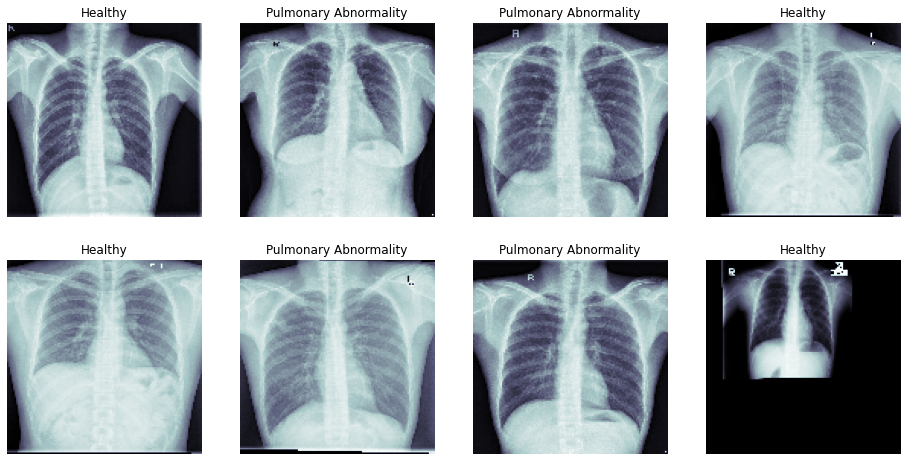

In [4]:
import matplotlib.pyplot as plt

label_to_name = (
    'Healthy',
    'Pulmonary Abnormality'
)

images, labels = next(train_generator)
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i, l, a in zip(images, labels, ax.flatten()):
    a.imshow(denormalize(i[:, :, 0]), cmap='bone')
    a.set_title(label_to_name[np.argmax(l)])
    a.axis('off')

Model is based on https://github.com/zeeshannisar/Transfer-Learning-and-Fine-Tuning-with-Pre-Trained-Networks/blob/master/Transfer%20Learning%20with%20VGG16/Fine%20tuning%20with%20Pretrained%20VGG16%20for%20Tuberculosis%20Classification.ipynb

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

CLASS_COUNT = 2 # normal and abnormal

In [6]:
def get_model(optimizer, learning_rate, dropout_rate, units):
    img_shape = (IMG_SIZE, IMG_SIZE, 3)
    vgg16_model = VGG16(input_shape=img_shape,
                        include_top=False, weights='imagenet')
    vgg16_model.trainable = False

    inputs = Input(img_shape)
    outputs = vgg16_model(inputs)
    outputs = BatchNormalization(name='BatchNormalization')(outputs)
    outputs = GlobalAveragePooling2D()(outputs)
    outputs = Dropout(dropout_rate)(outputs)
    outputs = Dense(units)(outputs)
    outputs = LeakyReLU(alpha=0.1)(outputs)
    outputs = Dropout(dropout_rate)(outputs)
    outputs = Dense(CLASS_COUNT, activation='sigmoid')(outputs)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(
        optimizer(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.FalseNegatives()
        ]
    )

    model.summary()
    return model

In [7]:
TRAIN_COUNT = train_generator.samples
VALIDATION_COUNT = validation_generator.samples
TUNE_EPOCHS = 100

In [8]:
HYPERPARAMETERS = {
    'optimizer': [tf.keras.optimizers.Adam],
    'learning_rate': [1e-4, 2e-4, 3e-4],
    'dropout_rate': [i/10 for i in range(3, 6)],
    'units': [256]
}

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

def get_callbacks(idx):
    checkpoint_callback = ModelCheckpoint(
        f'checkpoint/{idx}/100',
        monitor='val_accuracy',
        verbose=1,
        mode='max',
        save_best_only=True
    )
    stop_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=15)
    board_callback = TensorBoard(log_dir=f'logs/cyclegan2')
    
    return checkpoint_callback, stop_callback, board_callback

In [10]:
trainDir = '../xrays_cyclegan2/train'
validDir = '../xrays_256/validate'

IMG_SIZE = 128
BATCH_SIZE = 16
image_generator = ImageDataGenerator(preprocessing_function=normalize)

flow_args = {
    'target_size': (IMG_SIZE, IMG_SIZE),
    'color_mode': 'rgb',
    'batch_size': BATCH_SIZE,
    'class_mode': 'categorical',
    'shuffle': True,
    'seed': 1
}

train_generator = image_generator.flow_from_directory(
    directory=trainDir,
    **flow_args
)

validation_generator = image_generator.flow_from_directory(
    directory=validDir,
    **flow_args
)

Found 1002 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

def get_callbacks(idx):
    checkpoint_callback = ModelCheckpoint(
        f'checkpoint/cyclegan2',
        monitor='val_accuracy',
        verbose=1,
        mode='max',
        save_best_only=True
    )
    board_callback = TensorBoard(log_dir=f'logs/cyclegan1')
    
    return checkpoint_callback, board_callback

In [12]:
TRAIN_COUNT = train_generator.samples

In [17]:
model = tf.keras.models.load_model('checkpoint/cyclegan2')

In [18]:
model.fit(
    train_generator,
    steps_per_epoch=ceil(TRAIN_COUNT/BATCH_SIZE),
    validation_data=validation_generator,
    validation_steps=ceil(VALIDATION_COUNT/BATCH_SIZE),
    epochs=TUNE_EPOCHS,
    callbacks=get_callbacks(i),
    initial_epoch=49
)

Epoch 50/100
63/63 [==============================] - 12s 136ms/step - loss: 0.4650 - accuracy: 0.8034 - false_positives_1: 204.0000 - false_negatives_1: 203.0000 - val_loss: 0.4299 - val_accuracy: 0.8734 - val_false_positives_1: 10.0000 - val_false_negatives_1: 10.0000

Epoch 00050: val_accuracy improved from -inf to 0.87342, saving model to checkpoint/cyclegan2
INFO:tensorflow:Assets written to: checkpoint/cyclegan2/assets
Epoch 51/100
63/63 [==============================] - 4s 57ms/step - loss: 0.4470 - accuracy: 0.8244 - false_positives_1: 184.0000 - false_negatives_1: 195.0000 - val_loss: 0.3963 - val_accuracy: 0.8734 - val_false_positives_1: 10.0000 - val_false_negatives_1: 10.0000

Epoch 00051: val_accuracy did not improve from 0.87342
Epoch 52/100
63/63 [==============================] - 4s 58ms/step - loss: 0.4087 - accuracy: 0.8383 - false_positives_1: 168.0000 - false_negatives_1: 156.0000 - val_loss: 0.3792 - val_accuracy: 0.8734 - val_false_positives_1: 10.0000 - val_fals


Epoch 00074: val_accuracy did not improve from 0.88608
Epoch 75/100
63/63 [==============================] - 4s 58ms/step - loss: 0.2615 - accuracy: 0.8942 - false_positives_1: 109.0000 - false_negatives_1: 111.0000 - val_loss: 0.3890 - val_accuracy: 0.8608 - val_false_positives_1: 11.0000 - val_false_negatives_1: 11.0000

Epoch 00075: val_accuracy did not improve from 0.88608
Epoch 76/100
63/63 [==============================] - 4s 58ms/step - loss: 0.2763 - accuracy: 0.8832 - false_positives_1: 120.0000 - false_negatives_1: 119.0000 - val_loss: 0.3997 - val_accuracy: 0.8608 - val_false_positives_1: 11.0000 - val_false_negatives_1: 11.0000

Epoch 00076: val_accuracy did not improve from 0.88608
Epoch 77/100
63/63 [==============================] - 4s 58ms/step - loss: 0.2611 - accuracy: 0.8992 - false_positives_1: 98.0000 - false_negatives_1: 108.0000 - val_loss: 0.4029 - val_accuracy: 0.8608 - val_false_positives_1: 11.0000 - val_false_negatives_1: 11.0000

Epoch 00077: val_accuracy

63/63 [==============================] - 4s 58ms/step - loss: 0.2133 - accuracy: 0.9102 - false_positives_1: 87.0000 - false_negatives_1: 92.0000 - val_loss: 0.4285 - val_accuracy: 0.8608 - val_false_positives_1: 11.0000 - val_false_negatives_1: 11.0000

Epoch 00100: val_accuracy did not improve from 0.88608


In [19]:
%load_ext tensorboard
%tensorboard --logdir logs/cyclegan2

## Test model augmented with FastGAN

In [21]:
test_dir = '../xrays_256/test'

In [23]:
test_generator = image_generator.flow_from_directory(
    directory=test_dir,
    **flow_args
)

Found 79 images belonging to 2 classes.


In [25]:
TEST_COUNT = test_generator.samples

In [26]:
print('Evaluate model with best hyperparameters on test data:')
for hp, v in zip((k for k in HYPERPARAMETERS), (tf.keras.optimizers.Adam, 3e-4, 0.3, 256)):
    print(f'{hp}: {v}')

model = tf.keras.models.load_model(f'checkpoint/cyclegan2')
metrics = model.evaluate(
    test_generator,
    steps=ceil(TEST_COUNT/BATCH_SIZE),
    return_dict=True
)
accuracy = metrics['accuracy']
false_positives = metrics[f'false_positives_1']
false_negatives = metrics[f'false_negatives_1']

print(f'Accuracy on test data: {accuracy:.2f}')
print(f'False positives: {false_positives:.2f}')
print(f'False negatives: {false_negatives:.2f}')

Evaluate model with best hyperparameters on test data:
optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
learning_rate: 0.0003
dropout_rate: 0.3
units: 256
5/5 [==============================] - 1s 55ms/step - loss: 0.5694 - accuracy: 0.7595 - false_positives_1: 19.0000 - false_negatives_1: 20.0000
Accuracy on test data: 0.76
False positives: 19.00
False negatives: 20.00
